In [1]:
%matplotlib inline
from tools import *

# Ch04 数据表示与特征工程

-   连续特征 ( Continuous Feature ) 。
-   分类特征 ( Categorical Feature ) ，也叫离散特征 ( Discrete Feature ) 。

特征工程：找到最佳的数据表示。

虽然神经网络已经可以自动完成特征的选择和变换，但是深入学习特征变换的原理，可以帮助理解神经网络对数据进行了哪种变化，从而加深对数据的理解，能够更加显式地操纵数据变换过程，提高数据变换的效率和加入更多的先验信息。

## 4.6 利用专家知识 ( Expert Knowledge )

[自行车出租数据](https://www.citibikenyc.com/system-data)

通过对数据特征的不断优化，通过特征变换将专家的先验知识加入到数据中，可以显著提高模型的精确度。

通过对比不同的模型，还可以进一步了解模型处理数据时的分别。

In [2]:
citibike = mglearn.datasets.load_citibike()

In [3]:
print("Citi Bike data:\n{}".format(citibike.head()))

Citi Bike data:
starttime
2015-08-01 00:00:00     3
2015-08-01 03:00:00     0
2015-08-01 06:00:00     9
2015-08-01 09:00:00    41
2015-08-01 12:00:00    39
Freq: 3H, Name: one, dtype: int64


In [4]:
xticks = pd.date_range(start=citibike.index.min(), end=citibike.index.max(),freq='D')
print("xticks.shape=",xticks.shape)

xticks.shape= (31,)


Text(0.5, 1.0, '图4-12：对于选定的 Citi Bike 站点，自行车出租数量随时间的变化')

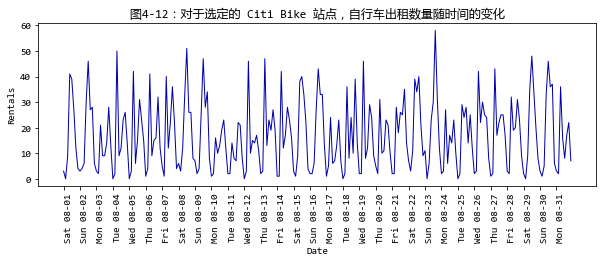

In [5]:
plt.figure(figsize=(10, 3))
plt.xticks(xticks, xticks.strftime("%a %m-%d"), rotation=90, ha="left")
plt.plot(citibike, linewidth=1)
plt.xlabel("Date")
plt.ylabel("Rentals")
plt.title("图4-12：对于选定的 Citi Bike 站点，自行车出租数量随时间的变化")

In [6]:
# extract the target values (number of rentals)
y = citibike.values
# convert to POSIX time by dividing by 10**9
# 使用 POSIX 时间格式作为数据特征
X = citibike.index.astype("int64").values.reshape(-1, 1) // 10**9

In [7]:
# use the first 184 data points for training, the rest for testing
n_train = 184

# function to evaluate and plot a regressor on a given feature set
def eval_on_features(features, target, regressor):
    # split the given features into a training and a test set
    X_train, X_test = features[:n_train], features[n_train:]
    # also split the target array
    y_train, y_test = target[:n_train], target[n_train:]
    regressor.fit(X_train, y_train)
    print("X_train.shape=",X_train.shape)
    print("Test-set R^2: {:.2f}".format(regressor.score(X_test, y_test)))
    y_pred = regressor.predict(X_test)
    y_pred_train = regressor.predict(X_train)
    plt.figure(figsize=(10, 3))

    plt.xticks(range(0, len(X), 8), xticks.strftime("%a %m-%d"), rotation=90,ha="left")

    plt.plot(range(n_train), y_train, label="训练集")
    plt.plot(range(n_train, len(y_test) + n_train), y_test, '-', label="测试集")
    
    plt.plot(range(n_train), y_pred_train, '--', label="基于训练集的预测")
    plt.plot(range(n_train, len(y_test) + n_train), y_pred, '--',label="基于测试集的预测")
    
    plt.legend(loc=(1.01, 0))
    plt.xlabel("Date")
    plt.ylabel("Rentals")

X_train.shape= (184, 1)
Test-set R^2: -0.04


Text(0.5, 1.0, '图4-13：随机森林仅使用 POSIX 时间做出的预测')

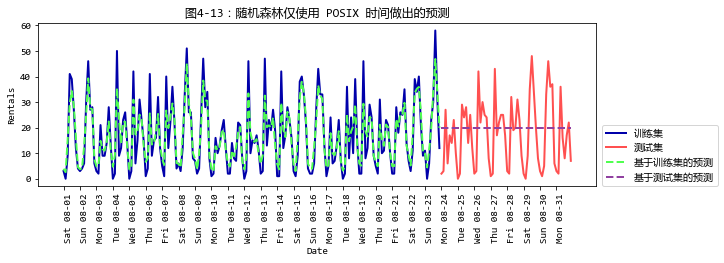

In [8]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators=100, random_state=0)
eval_on_features(X, y, regressor)
plt.title("图4-13：随机森林仅使用 POSIX 时间做出的预测")

X_train.shape= (184, 1)
Test-set R^2: 0.60


Text(0.5, 1.0, '图4-14：随机森林使用每天的小时做出的预测')

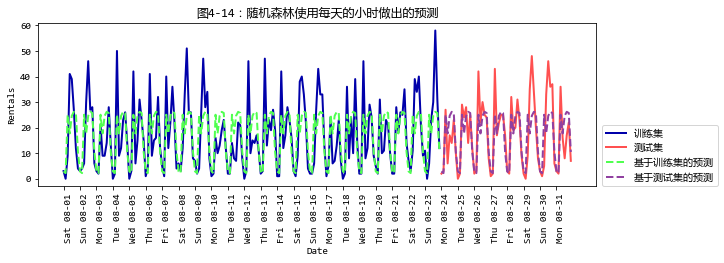

In [9]:
# 使用小时这个特征进行训练
X_hour = citibike.index.hour.values.reshape(-1, 1)
eval_on_features(X_hour, y, regressor)
plt.title("图4-14：随机森林使用每天的小时做出的预测")

X_train.shape= (184, 2)
Test-set R^2: 0.84


Text(0.5, 1.0, '图4-15：随机森林使用一周的星期几和每天的小时两个特征做出的预测')

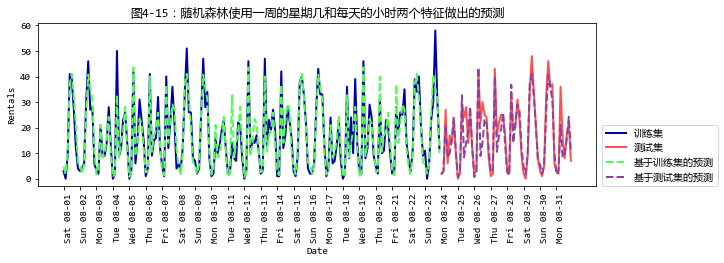

In [10]:
# 组合每周星期几的特征和小时特征
X_hour_week = np.hstack([citibike.index.dayofweek.values.reshape(-1, 1),
                         citibike.index.hour.values.reshape(-1, 1)])
eval_on_features(X_hour_week, y, regressor)
plt.title("图4-15：随机森林使用一周的星期几和每天的小时两个特征做出的预测")

X_train.shape= (184, 2)
Test-set R^2: 0.13


Text(0.5, 1.0, '图4-16：线性模型使用一周的星期几和每天的小时两个特征做出的预测')

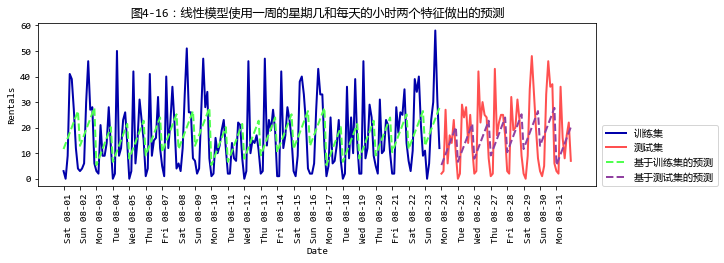

In [11]:
# 精度变差，是因为整数编码的特征被解释为连续变量
# 线性模型只能学到关于每天时间的线性函数，不能针对每个小时单独学习
from sklearn.linear_model import LinearRegression
eval_on_features(X_hour_week, y, LinearRegression())
plt.title("图4-16：线性模型使用一周的星期几和每天的小时两个特征做出的预测")

X_train.shape= (184, 15)
Test-set R^2: 0.62


Text(0.5, 1.0, '图4-17：线性模型使用OneHot编码过的一周的星期几和每天的小时两个特征做出的预测')

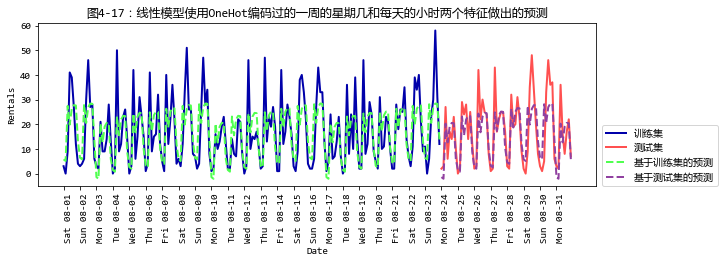

In [12]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge
enc = OneHotEncoder()
X_hour_week_onehot = enc.fit_transform(X_hour_week).toarray()
eval_on_features(X_hour_week_onehot, y, Ridge())
plt.title("图4-17：线性模型使用OneHot编码过的一周的星期几和每天的小时两个特征做出的预测")

X_train.shape= (184, 120)
Test-set R^2: 0.85


Text(0.5, 1.0, '图4-18：线性模型使用经过 One-Hot 编码的特征映射为多项式特征作为先验知识做出的预测')

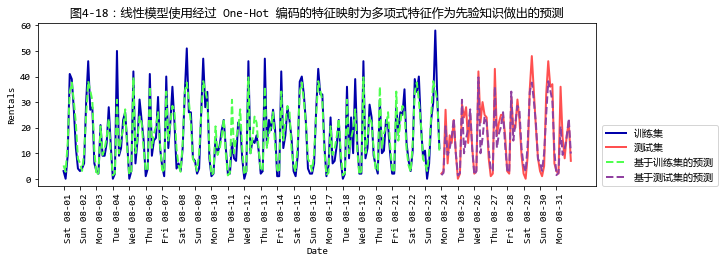

In [13]:
from sklearn.preprocessing import PolynomialFeatures
poly_transformer = PolynomialFeatures(degree=2, interaction_only=True,include_bias=False)
X_hour_week_onehot_poly = poly_transformer.fit_transform(X_hour_week_onehot)
lr = Ridge()
eval_on_features(X_hour_week_onehot_poly, y, lr)
plt.title("图4-18：线性模型使用经过 One-Hot 编码的特征映射为多项式特征作为先验知识做出的预测")

In [14]:
hour = ["%02d:00" % i for i in range(0, 24, 3)]
day = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
features =  day + hour

In [15]:
features_poly = poly_transformer.get_feature_names(features)
nonzero_idx=(lr.coef_ !=0)
features_nonzero = np.array(features_poly)[nonzero_idx]
coef_nonzero = lr.coef_[nonzero_idx]

Text(0.5, 1.0, '图4-19：线性模型使用经过 One-Hot 编码的特征映射为多项式特征作为先验知识学到的系数')

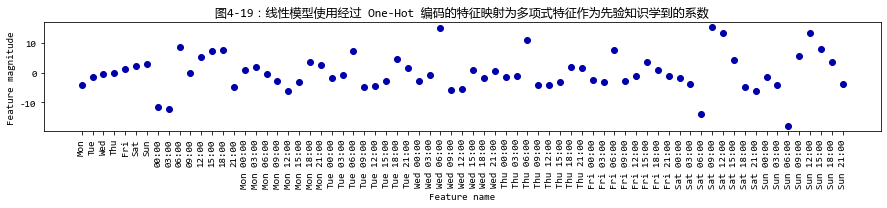

In [17]:
plt.figure(figsize=(15, 2))
plt.plot(coef_nonzero, 'o')
plt.xticks(np.arange(len(coef_nonzero)), features_nonzero, rotation=90)
plt.xlabel("Feature name")
plt.ylabel("Feature magnitude")
plt.title("图4-19：线性模型使用经过 One-Hot 编码的特征映射为多项式特征作为先验知识学到的系数")

## 4.7 小结与展望

-   特征的重要性
-   构造好的特征可以使用简单的模型获取高的精度，并且使模型和特征的解释性更强，更方便理解
-   基于复杂的模型从而跳过人工构造特征的过程。